In [2]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Setup and read data. The data is not included in this repo. Data is expected to be located in ../data/skyhook/ directory.

In [4]:
skyhook_col_types = {
"tide5id_100m" : str,
"mac_oui" : str,
"ssid" : str,
"lat" : float,
"lon" : float ,
"rq_time" : str, # we parse this as date with parse_dates parameter in read_csv call later
"zcta" : int,
"zcta_city" : str,
"zcta_county" : str,
"zcta_state" : str
}

skyhook_data = pd.read_csv("../data/skyhook/p1059_nau_oui_20210301.csv", dtype=skyhook_col_types, parse_dates=['rq_time'])

Read in Hopi shape and subset samples to those that lie within

In [72]:
aiannh = geopandas.read_file('../data/aiannh/tl_2019_us_aiannh.shp')
aiannh.set_index('AIANNHCE')
aiannh['AIANNHCE']

0      2320
1      9100
2      4110
3      1380
4      1110
       ... 
843    5970
844    5955
845    4910
846    4930
847    4940
Name: AIANNHCE, Length: 848, dtype: object

Summary statistics of times of measurements and counts.

In [6]:
print(skyhook_data[['rq_time']].describe(datetime_is_numeric=True))

                             rq_time
count                        1291723
mean   2020-09-17 07:06:19.692180224
min              2019-09-07 00:04:19
25%       2020-05-20 19:33:33.500000
50%              2020-10-29 23:15:28
75%       2021-02-21 01:56:43.500000
max              2021-03-07 23:59:52


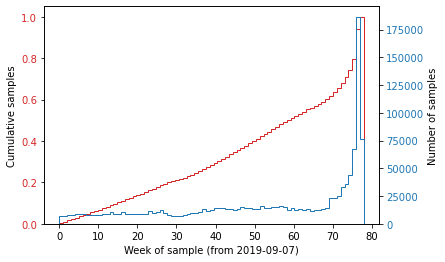

In [8]:
weekly_counts = skyhook_data.resample('7d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = weekly_counts.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts, density=True, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Week of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=weekly_counts, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

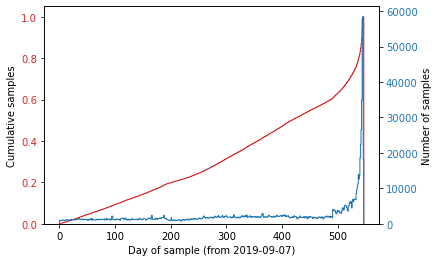

In [10]:

daily_counts = skyhook_data.resample('1d', on='rq_time')['rq_time'].count()

cdf_color = 'tab:red'
hist_color = 'tab:blue'

num_bin = daily_counts.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts, density=True, cumulative=True, histtype='step', color=cdf_color)
cdf_ax.tick_params(axis='y', labelcolor=cdf_color)
plt.ylabel("Cumulative samples")
plt.xlabel("Day of sample (from 2019-09-07)")

hist_ax = cdf_ax.twinx()

hist_ax.hist(np.arange(0,num_bin), num_bin, weights=daily_counts, histtype='step', color=hist_color)
hist_ax.tick_params(axis='y', labelcolor=hist_color)
plt.ylabel("Number of samples")
plt.show()

In [12]:
area_data = skyhook_data['tide5id_100m'].groupby(skyhook_data['tide5id_100m']).count().sort_values()
frequency_count_measurement = area_data.groupby(area_data).count()

area_data.describe()


count    85510.000000
mean        15.106105
std         90.261841
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max      17363.000000
Name: tide5id_100m, dtype: float64

In [14]:
frequency_count_measurement.describe()

count      598.000000
mean       142.993311
std       1266.646053
min          1.000000
25%          1.000000
50%          2.000000
75%         11.000000
max      26625.000000
Name: tide5id_100m, dtype: float64

Creating a CDF of non-empty tiles

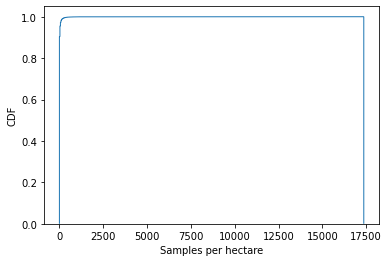

In [42]:
num_bin = frequency_count_measurement.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement.index, num_bin, weights=frequency_count_measurement.values, density=True, cumulative=True, histtype='step')
plt.ylabel("CDF")
plt.xlabel("Samples per hectare")


plt.show()

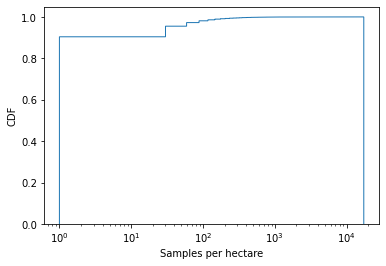

In [44]:
num_bin = frequency_count_measurement.shape[0]
fig, cdf_ax = plt.subplots()
cdf_ax.hist(frequency_count_measurement.index, num_bin, weights=frequency_count_measurement.values, density=True, cumulative=True, histtype='step')
plt.ylabel("CDF")
plt.xscale('log')
plt.xlabel("Samples per hectare")


plt.show()

In [40]:
frequency_count_measurement

tide5id_100m
1        26625
2        12107
3         6328
4         5130
5         3456
         ...  
3991         1
4755         1
5115         1
6217         1
17363        1
Name: tide5id_100m, Length: 598, dtype: int64

Unfortunately we can not derive empty tiles from this method because of the arbitrary nature of the tile IDs, so we will calculate the approximate proportion by finding our total measurement area and subtracting the area which contains measurements from our data set.

In [18]:
unique_ouis = skyhook_data['mac_oui'].drop_duplicates()

In [20]:
skyhook_data['mac_oui'].describe()

count     1291723
unique     422038
top        0080AE
freq        12792
Name: mac_oui, dtype: object

In [23]:
# this code should collect counts of OUI/week pairs, however the runtime is very long so I'm unsure it's functioning correctly.
oui_daily_counts = skyhook_data.groupby('mac_oui').resample('7d', on='rq_time')['rq_time'].count()

    

KeyboardInterrupt: 

In [ ]:
# weeks 0 - 70 proportion of OUIs vs weeks 80 - end proportion of OUIs
first_weeks = weekly_counts = skyhook_data.resample('7d', on='rq_time')['rq_time'].count()
